# IPCGANs

## Example 1

In [1]:
import sys
from PIL import Image

images = [Image.open(x) for x in 
          ['./age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/17_Dakota_Johnson_0009.jpg_0.jpg',
           './age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/17_Dakota_Johnson_0009.jpg_0.jpg_1.jpg',
           './age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/17_Dakota_Johnson_0009.jpg_0.jpg_2.jpg',
           './age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/17_Dakota_Johnson_0009.jpg_0.jpg_3.jpg',
           './age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/17_Dakota_Johnson_0009.jpg_0.jpg_4.jpg']]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

new_im.save('Dakota_Johnson.jpg')

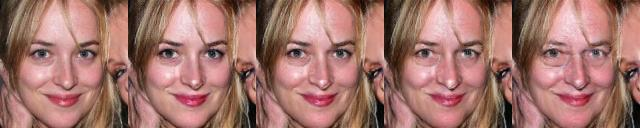

In [2]:
from IPython.display import Image
Image(filename='Dakota_Johnson.jpg') 

## Example 2

In [3]:
import sys
from PIL import Image

images = [Image.open(x) for x in 
          ['./age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/15_Chris_Colfer_0009.jpg_0.jpg',
           './age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/15_Chris_Colfer_0009.jpg_0.jpg_1.jpg',
           './age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/15_Chris_Colfer_0009.jpg_0.jpg_2.jpg',
           './age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/15_Chris_Colfer_0009.jpg_0.jpg_3.jpg',
           './age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/15_Chris_Colfer_0009.jpg_0.jpg_4.jpg']]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

new_im.save('Kit_Harington.jpg')

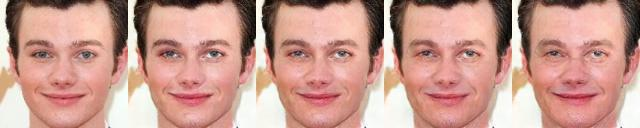

In [4]:
from IPython.display import Image
Image(filename='Chris_Colfer.jpg') 

## Face Recognition using DeepFace

In [5]:
import os
from os import listdir
import numpy as np
import cv2
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt

from keras.models import model_from_json

Using Theano backend.


In [6]:
target_size = (152, 152)

#-----------------------

#OpenCV haarcascade module

opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]
path = folders[0]
for folder in folders[1:]:
    path = path + "/" + folder

detector_path = path+"/data/haarcascade_frontalface_default.xml"

if os.path.isfile(detector_path) != True:
    raise ValueError("Confirm that opencv is installed on your environment! Expected path ",detector_path," violated.")
else:
    face_cascade = cv2.CascadeClassifier(detector_path)

In [7]:
def detectFace(img_path, target_size=(152, 152)):

    img = cv2.imread(img_path)

    faces = face_cascade.detectMultiScale(img, 1.3, 5)

    if len(faces) > 0:
        x,y,w,h = faces[0]

        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100

        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]

        detected_face = cv2.resize(detected_face, target_size)

        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)

        #normalize in [0, 1]
        img_pixels /= 255 

        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")

#-------------------------

In [8]:
#DeepFace model
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))

base_model.load_weights("VGGFace2_DeepFace_weights_val-0.9034.h5")

/home/ec2-user/anaconda3/lib/python3.6/site-packages/keras/utils/conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [9]:
#Drop F8 and D0 layers. F7 is the representation layer.
model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-3].output)

In [10]:
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

In [11]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [12]:
dataset = [
    ['age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/17_Dakota_Johnson_0009.jpg_0.jpg', 'age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/17_Dakota_Johnson_0009.jpg_0.jpg_4.jpg'],
    ['age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/15_Chris_Colfer_0009.jpg_0.jpg_4.jpg', 'age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/17_Dakota_Johnson_0009.jpg_0.jpg_4.jpg'],
    ['./age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/15_Chris_Colfer_0009.jpg_0.jpg', 'age/0_conv5_lsgan_transfer_g75_0.5f-4_a30/15_Chris_Colfer_0009.jpg_0.jpg_4.jpg']
]

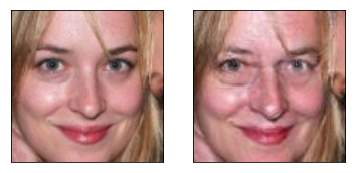

Euclidean distance: 14.41015
 - Predicted:  True
----------------------------------------------


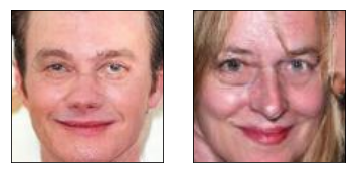

Euclidean distance: 65.19117
 - Predicted:  False
----------------------------------------------


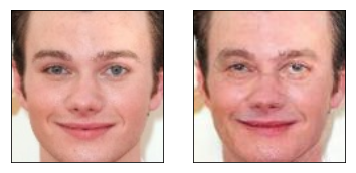

Euclidean distance: 18.158958
 - Predicted:  True
----------------------------------------------


In [13]:
for case in dataset:
    img1_path = case[0]
    img2_path = case[1]
    
    img1 = detectFace(img1_path)
    img2 = detectFace(img2_path)
    
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(img1[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    fig.add_subplot(1,2, 2)
    plt.imshow(img2[0][:, :, ::-1])
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    img1_embedding = base_model.predict(img1)[0] 
    img2_embedding = base_model.predict(img2)[0] 

    euclidean_distance = findEuclideanDistance(img1_embedding, img2_embedding) 
   
    print("Euclidean distance:", euclidean_distance)
    
    if euclidean_distance <= 50:
        verified = True
    else:
        verified = False

    print(" - Predicted: ", verified)

    print("----------------------------------------------")